In [6]:
# this sets where to look for inputs and store outputs
import os
os.environ["SPYFFIDATA"] = '/Users/zkbt/Cosmos/Data/TESS/FFIs'

In [7]:
# this makes sure that updates are actually printed to the terminal 
import logging
logging.basicConfig(level="INFO")

In [8]:
# this loads a default observation definition
from spyffi.Observation import Observation, default
inputs = default

In [9]:
# what kind of catalog does this use?
print inputs['catalog']

{'skykw': {'faintlimit': None, 'fast': False}, 'catalogue': 'UCAC4', 'starsarevariable': True, 'name': 'sky', 'lckw': {'fractionwithextremelc': 0.005, 'fractionofstarswithlc': 0.5, 'fractionwithcustom': 0.1, 'fractionwithrotation': 0.2, 'seed': 0, 'fainteststarwithlc': None, 'options': ['trapezoid', 'sin'], 'fractionwithtrapezoid': 0.3}, 'testpatternkw': {'randomizenudgesby': 21.1, 'randomizepropermotionsby': 0.0, 'spacing': 500.0, 'magnitudes': [10, 10], 'randomizemagnitudes': False}}


In [21]:
# set up some transits in a testpattern
inputs['camera']['label'] = 'transit'
inputs['catalog']['name'] = 'testpattern'
inputs['camera']['subarray'] = 200
inputs['camera']['variablefocus'] = False
inputs['expose']['jitterscale'] = 1.0
inputs['expose']['skipcosmics'] = False
inputs['expose']['writecosmics'] = True

inputs['catalog']['testpatternkw']['randomizemagnitudes'] = True
inputs['catalog']['testpatternkw']['magnitudes'] = [6,16]

# how many of each exposure duration should we make?
inputs['observation']['cadencestodo'] = {120:216}
o = Observation(inputs)

INFO:spyffi.Observation:  creating a new observation, with the following inputs:
INFO:spyffi.Observation:      inputs[expose] = 
INFO:spyffi.Observation:                 magnitudethreshold:999
INFO:spyffi.Observation:                             jitter:True
INFO:spyffi.Observation:                     correctcosmics:True
INFO:spyffi.Observation:                              smear:False
INFO:spyffi.Observation:                   cosmicsdiffusion:True
INFO:spyffi.Observation:                           compress:{120: True, 1800: False, 2: True, 20: True}
INFO:spyffi.Observation:                     cosmicsversion:fancy
INFO:spyffi.Observation:                       writecosmics:False
INFO:spyffi.Observation:                     writesimulated:True
INFO:spyffi.Observation:                        skipcosmics:False
INFO:spyffi.Observation:                        jitterscale:1.0
INFO:spyffi.Observation:                     writenoiseless:False
INFO:spyffi.Observation:                         

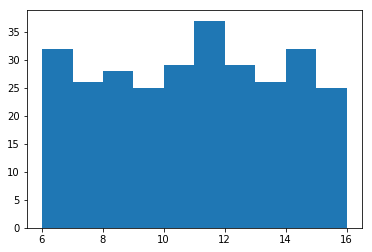

In [22]:
# generate some light curves to populate the catalog
import spyffi.Lightcurve as lc, numpy as np
for i in range(len(o.camera.catalog.ra)):
    o.camera.catalog.lightcurves[i] = lc.constant()

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(o.camera.catalog.tmag)


ra, dec = o.camera.catalog.ra, o.camera.catalog.dec
coord = o.camera.cartographer.point(ra, dec, 'celestial')
x, y = coord.ccdxy.tuple

n = o.camera.ccds[0].xsize
ok = (x > 0)*(x < n)*(y < n)*(y > 0)
ok *= (o.camera.catalog.tmag < 11.0)
lucky = np.random.choice(np.nonzero(ok)[0], 1)[0]
o.camera.catalog.lightcurves[lucky] = lc.Trapezoid(P=0.3, 
                                                   E=2457827.0 + 0.15, 
                                                   D=1.0, 
                                                   T23=0.00, 
                                                   T14=0.1)

In [23]:
print o.camera.catalog.lightcurves

[<constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()>
 <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()>
 <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()>
 <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constant()> <constan

<Trapezoid(T14=0.1,P=0.3,T23=0.0,E=2457827.15,D=1.0)>


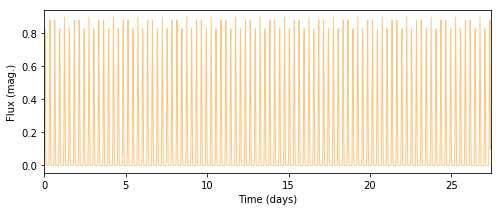

In [ ]:
%matplotlib inline 
l = o.camera.catalog.lightcurves[lucky]
l.demo()
print l

In [ ]:
o.create()

INFO:spyffi.Camera:setting cadence to 120 seconds = 60 reads.
INFO:spyffi.Jitter:populating the jitterball for 120 second cadence, based on the raw jitter file cartoon.jitter.cadence120s.unscaled.
INFO:spyffi.PSF:initializing PSF painter, based on woods_prf_feb2016/RAYS_ptSrc_wSi_Oct27model_AP40.6_75C_F3p314adj
INFO:spyffi.Intrapixel:creating an intrapixel sensitivity map called perfectpixels
INFO:spyffi.PSF:setting up the pixel arrays
INFO:spyffi.PSF:created pixel coordinate arrays
INFO:spyffi.CCD:created CCD #1, of size 21x21
INFO:spyffi.PSF:trying to load PSFs from /Users/zkbt/Cosmos/Data/TESS/FFIs/intermediates/psfs/RRUasbuilt/focus0and10_stellartemp4350/pixelizedlibrary_cartoon.jitter.cadence120s.unscaled_perfectpixels_11positions_11offsets.npy
INFO:spyffi.PSF:...success!
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.Catalogs:save projected star catalog /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/catalog_t

INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/simulated_testpattern_6to16_sub200x200_000002.fits
INFO:spyffi.CCD:created image #0000002 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.154655106366,0.364365013136 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.00417 = 2017.20055898
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.1 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to

INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.1 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/photonnoise.fits
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.09; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.01; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pas

INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/photonnoise.fits
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.08; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
IN

INFO:spyffi.CCD:        the max saturation fraction is 1.10; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.01; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #3 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 15 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/simulated_testpattern_6to16_sub200x200_000015.fits


INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 19 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/simulated_testpattern_6to16_sub200x200_000019.fits
INFO:spyffi.CCD:created image #0000019 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.33494273932,-0.272419176444 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.02778 = 2017.20062362
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipp

INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 23 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/simulated_testpattern_6to16_sub200x200_000023.fits
INFO:spyffi.CCD:created image #0000023 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to 0.189897986943,-0.204858809793 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.03333 = 2017.20063883
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.1 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
I

INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.00821425398972,0.11682375934 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.03889 = 2017.20065404
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.1 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/photonnoise.fits
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation f

INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/photonnoise.fits
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.08; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    =

INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.08; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #3 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 36 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub2

INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 40 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/simulated_testpattern_6to16_sub200x200_000040.fits
INFO:spyffi.CCD:created image #0000040 of testpattern with 120s cadence
INFO:spyffi.Jitter:updated header keywords
INFO:spyffi.Jitter:nudged the camera to -0.162892675665,0.0184612325505 away from nominal pointing.
INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.05694 = 2017.20070348
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.1 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds


INFO:spyffi.CCD:projecting the starmap onto CCD
INFO:spyffi.CCD:taking a snapshot at 2457827.0625 = 2017.20071869
INFO:spyffi.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:spyffi.CCD:  done!
INFO:spyffi.CCD:skipping differental velocity aberration
INFO:spyffi.CCD:adding 81 stars between 6.1 and 16.0 magnitudes
INFO:spyffi.CCD:the camera's focus is set to 0.0
INFO:spyffi.CCD:adding backgrounds
INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/photonnoise.fits
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.08; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:     

INFO:spyffi.CCD:adding photon noise [sqrt(photons from stars and various backgrounds)]
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/photonnoise.fits
INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.08; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #3 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x20

INFO:spyffi.CCD:adding cosmic rays
INFO:spyffi.CCD:bleeding saturated pixels
INFO:spyffi.CCD:    on pass #1 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.08; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:    on pass #2 through saturation filter:
INFO:spyffi.CCD:        the max saturation fraction is 1.00; flux change over entire image is 0.00 electrons
INFO:spyffi.CCD:saving 200x200 image with type float32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/saturation_150000p0K.fits
INFO:spyffi.CCD:adding read noise
INFO:spyffi.CCD:    = quadrature sum of 60 reads with 10.0 e- each.
INFO:spyffi.CCD:saving simulated exposure 53 for sub200x200
INFO:spyffi.CCD:saving 200x200 image with type int32 to
INFO:spyffi.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_transit/120s/sub200x200/simulated_testpattern_6to16_sub200x200_000053.fits
INFO:spyffi.CCD:created image #0